In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from main_classes.ParamsCreator import (
    DataParams,
    LabelsParams,
    TimeseriesParams,
    ModelParams,
    ParamsParser
)

from main_classes.DataProcessor import DataProcessor 

from main_classes.DataRetriever import load_npz

from main_classes.ResultDisplayer import plot_pred, plot_mcdropout, plot_config_prediction

from utils.utils import create_empty_dict
from utils.process_helpers import create_real_dict, adjust_indexes, split_trials_from_scanpath

from utils.ScanMatchCalculator import (
    ScanMatch_Struct, 
    ScanMatch_CreateSubMatrix, 
    ScanMatch_GridMask,
    ScanMatch_FixationToSequence, 
    ScanMatch_NumToDoubleStr, 
    ScanMatch_DoubleStrToNum,
    ScanMatch_nwAlgo,
    ScanMatch
)

In [4]:
# Parameters for load data
data_params = DataParams(
    DATA_FOLDER="../../../data/",
    IMGS_FOLDER="../../../data/images/", 
    HEIGHT_ORIG=1080, 
    WIDTH_ORIG=1920, 
    HEIGHT=768, 
    WIDTH=1024
)

# Parameters for create labels
labels_params = LabelsParams(
    TRAIN_IMG_TYPE="natural", #natural, grey, black, inverted, white_noise, pink_noise, white
    TARGET_STEPS_AHEAD=1
)

# Parameters to create time series
timeseries_params = TimeseriesParams(
    SEQ_LENGTH=10 #200
)

# Parameters for learning
model_params = ModelParams(
    INPUT_UNITS=30, 
    LEARNING_RATE=0.0001, 
    EPOCHS=500,
    PATIENCE=15
)

params = ParamsParser(
    data_params,
    labels_params,
    timeseries_params,
    model_params,
    RESULTS_FOLDER="../../results/sanity_checks/",  #"../results/MCDropout/", 
    CHECKPOINTS_FOLDER="../../checkpoints/sanity_checks/",  #"../checkpoints/MCDropout/",
    N_MC_SAMPLES=30,
    is_train=True,
    is_save=True,
    is_save_figs=False,
    load_model=True
)

# [X] Check duration multimatch metric

In [5]:
import multimatch_gaze as m
from main_classes.MetricsCalculator import calculate_multimatch
# Params
N = 11
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 5000, 150

tIMG = "natural"
predIMG = "natural"

# Subject
subject_train = "s620" #s605, s617, s620

# Foldersfolder_path_themselves
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(params.RESULTS_FOLDER,
                          train_path)

## [X] Test eyeBehaviour

In [6]:
folder_path_themselves

'../../results/sanity_checks/SUBJECT_s620-tIMG_natural-N_11-Nt_1-SEQ_10-InUts_30-LR_0.0001-EPOCHS_5000-PAT_150'

In [7]:
from main_classes.MetricsCalculator import detect_sac_fix_from_scanpath
import json

# Load results
y_real, y_pred = load_npz(folder_path_themselves, 
                          predIMG, 
                          get_mcdropout_results=False)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)

# Test eye Behaviour
sac_real, fix_real = detect_sac_fix_from_scanpath(y_real)
sac_pred, fix_pred = detect_sac_fix_from_scanpath(y_pred)

# Plot
idx = np.expand_dims(np.arange(len(y_real)), -1)
y_real_plot = y_real.copy()
y_pred_plot = y_pred.copy()
y_real_plot.index = (idx*0.002).squeeze()
y_pred_plot.index = (idx*0.002).squeeze()

===========> Loading npz data from natural images


In [52]:
sacc_info, _ = detect_sac_fix_from_scanpath(y_real)
t_i, t_f = sacc_info["t_i"].astype(int), sacc_info["t_f"].astype(int)
block_arr = []
for idx_i, idx_f in zip(t_i, t_f):
    block_arr.append(y_real.iloc[idx_i:idx_f])
block_arr = pd.concat(block_arr).values

(0.0, 1000.0)

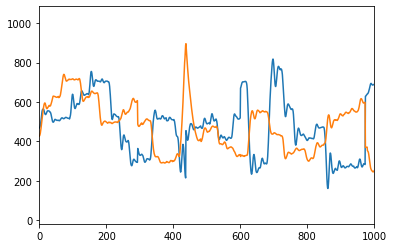

In [53]:
plt.plot(block_arr)
plt.xlim(0,1000)

In [ ]:
fix_real

In [ ]:
"""
sac_real["type"] = "SAC"
fix_real["type"] = "FIX"
df_path_real = pd.concat([sac_real, fix_real]).sort_values("t_i")
df_path_real

sac_pred["type"] = "SAC"
fix_pred["type"] = "FIX"
df_path_pred = pd.concat([sac_pred, fix_pred]).sort_values("t_i")
df_path_pred
"""

In [ ]:
# Plot
x_lim = None
for x_or_y in ["x", "y"]:
    # plot real vs pred
    plt.figure(figsize=(20,6))
    plt.plot(y_real_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.plot(y_pred_plot[x_or_y], 'C1*', label='pred', alpha=0.7)
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    # plot real vs eyebehaviour real
    plt.figure(figsize=(20,6))
    plt.plot(y_real_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    xy = f"start_{x_or_y}"
    #plt.step(df_path_real["duration"].cumsum(), df_path_real[xy], "C1-*", where="post", label="eyeBehaviour real")
    plt.step(fix_real["duration"].cumsum(), fix_real[xy], "C1-*", where="post", label="eyeBehaviour real")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    # plot pred vs eyebehaviour pred
    plt.figure(figsize=(20,6))
    plt.plot(y_pred_plot[x_or_y], 'C0*', label='pred', alpha=0.7)
    xy = f"start_{x_or_y}"
    plt.step(fix_pred["duration"].cumsum(), fix_pred[xy], "C1-*", where="post", label="eyeBehaviour pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    # eyebehaviour real vs eyebehaviour pred
    plt.figure(figsize=(20,6))
    xy = f"start_{x_or_y}"
    plt.step(fix_real["duration"].cumsum(), fix_real[xy], "C0-*", where="post", label="eyeBehaviour real")
    plt.step(fix_pred["duration"].cumsum(), fix_pred[xy], "C1-*", where="post", label="eyeBehaviour pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()

## [X] Test Remodnav

In [ ]:
from utils.MetricsCalculator import eyeBehaviour_remodnav, format_output_remodnav
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

# Test eye Behaviour
sac_real, fix_real_remodnav = detect_sac_fix_from_scanpath(y_real, fn="remodnav")
sac_pred, fix_pred_remodnav = detect_sac_fix_from_scanpath(y_pred, fn="remodnav")

# Plot
idx = np.expand_dims(np.arange(len(y_real)), -1)
y_real_plot = y_real.copy()
y_pred_plot = y_pred.copy()
y_real_plot.index = (idx*0.002).squeeze()
y_pred_plot.index = (idx*0.002).squeeze()

In [ ]:
# Plot
x_lim = (0,10)
for x_or_y in ["x", "y"]:
    # plot real vs pred
    plt.figure(figsize=(20,6))
    plt.plot(y_real_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.plot(y_pred_plot[x_or_y], 'C1*', label='pred', alpha=0.7)
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    # plot real vs eyebehaviour real
    plt.figure(figsize=(20,6))
    plt.plot(y_real_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    xy = f"start_{x_or_y}"
    plt.step(fix_real_remodnav["duration"].cumsum(), fix_real_remodnav[xy], "C1-*", where="post", label="Remodnav real")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    # plot pred vs eyebehaviour pred
    plt.figure(figsize=(20,6))
    plt.plot(y_pred_plot[x_or_y], 'C0*', label='pred', alpha=0.7)
    xy = f"start_{x_or_y}"
    plt.step(fix_pred_remodnav["duration"].cumsum(), fix_pred_remodnav[xy], "C1-*", where="post", label="Remodnav pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    # eyebehaviour real vs eyebehaviour pred
    plt.figure(figsize=(20,6))
    xy = f"start_{x_or_y}"
    plt.step(fix_real_remodnav["duration"].cumsum(), fix_real_remodnav[xy], "C0-*", where="post", label="Remodnav real")
    plt.step(fix_pred_remodnav["duration"].cumsum(), fix_pred_remodnav[xy], "C1-*", where="post", label="Remodnav pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()

## [X] Comparison eyeBehaviour vs Remodnav

In [ ]:
# Plot
x_lim = (0,10)
for x_or_y in ["x", "y"]:
    # eyebehaviour real vs remodnav real
    plt.figure(figsize=(20,6))
    xy = f"start_{x_or_y}"
    plt.plot(y_real_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.step(fix_real["duration"].cumsum(), fix_real[xy], "C1-*", where="post", label="eyeBehaviour real")
    plt.step(fix_real_remodnav["duration"].cumsum(), fix_real_remodnav[xy], "C2-*", where="post", label="Remodnav real")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()
    
    # eyebehaviour pred vs remodnav pred
    plt.figure(figsize=(20,6))
    xy = f"start_{x_or_y}"
    plt.plot(y_pred_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.step(fix_pred["duration"].cumsum(), fix_pred[xy], "C1-*", where="post", label="eyeBehaviour real")
    plt.step(fix_pred_remodnav["duration"].cumsum(), fix_pred_remodnav[xy], "C2-*", where="post", label="Remodnav real")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.show()

## [X] Test multimatch

In [ ]:
import multimatch_gaze as m
from utils.MetricsCalculator import calculate_multimatch
# Params
N = 11
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

tIMG = "natural"
predIMG = "natural"

# Subject
subject_train = "s620" #s605, s617, s620

# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(params.RESULTS_FOLDER,
                          train_path)

# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
print(calculate_multimatch(y_real, y_pred))
print(calculate_multimatch(y_real.reset_index(drop=True), y_pred.reset_index(drop=True)))

y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

# Test eye Behaviour
sac_real, fix_real = detect_sac_fix_from_scanpath(y_real, fn="eyeBehaviour")
sac_pred, fix_pred = detect_sac_fix_from_scanpath(y_pred, fn="eyeBehaviour")

# Plot
idx = np.expand_dims(np.arange(len(y_pred)), -1)
y_real_plot = y_real.copy()
y_pred_plot = y_pred.copy()
y_real_plot.index = (idx*0.002).squeeze()
y_pred_plot.index = (idx*0.002).squeeze()


In [ ]:
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
#print(calculate_multimatch(y_real, y_pred))
y_real

### [X] real == pred

In [ ]:
x_lim = (0, 10)
fix_pred = fix_real.copy()
print(m.docomparison(fix_real, fix_pred, screensize=[1920, 1080]))
for x_or_y in ["x", "y"]:
    plt.figure(figsize=(20,6))
    plt.plot(y_real_plot[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.step(fix_real["duration"].cumsum(), fix_real[xy], "C1-*", where="post", label="eyeBehaviour real")
    plt.step(fix_pred["duration"].cumsum(), fix_pred[xy], "C2-*", where="post", label="eyeBehaviour pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)

### [X] pred[duration] += number

In [ ]:
fix_pred = fix_real.copy()
#fix_pred["duration"] += 0.01
fix_pred["duration"] *= 0.9
print(m.docomparison(fix_real, fix_pred, screensize=[1920, 1080]))
for x_or_y in ["x", "y"]:
    plt.figure(figsize=(20,6))
    plt.step(fix_real["duration"].cumsum(), fix_real[xy], "C0-*", where="post", label="eyeBehaviour real")
    plt.step(fix_pred["duration"].cumsum(), fix_pred[xy], "C1-*", where="post", label="eyeBehaviour pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N)

### [X] Subject s622, mduration = 0.5

In [ ]:
# Params
N = 5
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

tIMG = "natural"
predIMG = "natural"

# Subjects
subject_train = "s622"

# Test against themselves
# -----------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(params.RESULTS_FOLDER,
                          train_path)
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

# Test eye Behaviour
sac_real_s622, fix_real_s622 = detect_sac_fix_from_scanpath(y_real, fn="eyeBehaviour")

# Plot
idx = np.expand_dims(np.arange(len(y_pred)), -1)
y_real_s622 = y_real.copy()
y_pred_s622 = y_pred.copy()
y_real_s622.index = (idx*0.002).squeeze()
y_pred_s622.index = (idx*0.002).squeeze()

In [ ]:
x_lim = (0, 15)
_, fix_pred_s622 = detect_sac_fix_from_scanpath(y_pred, fn="eyeBehaviour")
print(m.docomparison(fix_real_s622, fix_pred_s622, screensize=[1920, 1080]))
#print(m.docomparison(fix_real_s622[x_lim[0]:x_lim[1]].reset_index(drop=True), fix_pred_s622[x_lim[0]:x_lim[1]].reset_index(drop=True), screensize=[1920, 1080]))
for x_or_y in ["x", "y"]:
    plt.figure(figsize=(20,6))
    plt.step(fix_real_s622["duration"].cumsum(), fix_real_s622[xy], "C0-*", where="post", label="eyeBehaviour real")
    plt.step(fix_pred_s622["duration"].cumsum(), fix_pred_s622[xy], "C1-*", where="post", label="eyeBehaviour pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N, x_lim=x_lim)
    plt.xticks(fontsize=14)

### [X] Subject s620 mduration = 0.95

In [ ]:
# Params
N = 5
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

tIMG = "natural"
predIMG = "natural"

# Subjects
subject_train = "s620"

# Test against themselves
# -----------------------
# Folders
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(params.RESULTS_FOLDER,
                          train_path)
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
y_real.reset_index(inplace=True, drop=True)
y_pred.reset_index(inplace=True, drop=True)
mcdropout_mean.reset_index(inplace=True, drop=True)
mcdropout_std.reset_index(inplace=True, drop=True)

# Test eye Behaviour
sac_real_s620, fix_real_s620 = detect_sac_fix_from_scanpath(y_real, fn="eyeBehaviour")

# Plot
idx = np.expand_dims(np.arange(len(y_pred)), -1)
y_real_s620 = y_real.copy()
y_pred_s620 = y_pred.copy()
y_real_s620.index = (idx*0.002).squeeze()
y_pred_s620.index = (idx*0.002).squeeze()

In [ ]:
_, fix_pred_s620 = detect_sac_fix_from_scanpath(y_pred, fn="eyeBehaviour")
print(m.docomparison(fix_real_s620, fix_pred_s620, screensize=[1920, 1080]))
for x_or_y in ["x", "y"]:
    plt.figure(figsize=(20,6))
    plt.step(fix_real_s620["duration"].cumsum(), fix_real_s620[xy], "C0-*", where="post", label="eyeBehaviour real")
    plt.step(fix_pred_s620["duration"].cumsum(), fix_pred_s620[xy], "C1-*", where="post", label="eyeBehaviour pred")
    plot_config_prediction(x_or_y, subject_train, subject_train, N=N)

### [X] s620 vs s622

In [ ]:
print("s620:", m.docomparison(fix_real_s620, fix_pred_s620, screensize=[1920, 1080]))
print("s622:", m.docomparison(fix_real_s622, fix_pred_s622, screensize=[1920, 1080]))

for x_or_y in ["x", "y"]:
    plt.figure(figsize=(20,6))
    #plt.plot(y_real_s620[x_or_y], 'C0*', label='true s620', alpha=0.7)
    plt.step(fix_real_s620["duration"].cumsum(), fix_real_s620[xy], "C0-*", where="post", label="eyeBehaviour real s620")
    plt.step(fix_pred_s620["duration"].cumsum(), fix_pred_s620[xy], "C1-*", where="post", label="eyeBehaviour pred s620")
    plot_config_prediction(x_or_y, "s620", subject_train, N=N)
    
    plt.figure(figsize=(20,6))
    #plt.plot(y_real_s622[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.step(fix_real_s622["duration"].cumsum(), fix_real_s622[xy], "C0-*", where="post", label="eyeBehaviour real s622")
    plt.step(fix_pred_s622["duration"].cumsum(), fix_pred_s622[xy], "C1-*", where="post", label="eyeBehaviour pred s622")
    plot_config_prediction(x_or_y, "s622", subject_train, N=N)

# [$\checkmark$] Check Scanmatch 

In [ ]:
import scipy.io
mat = scipy.io.loadmat("ScanMatch_DataExample.mat")
data1 = mat["data1"]
data2 = mat["data2"]
data3 = mat["data3"]

In [ ]:
ScanMatchInfo = {
    "Xres": 1024,
    "Yres": 768,
    "Xbin": 12,
    "Ybin": 8,
    "RoiModulus": 12,
    "Threshold": 3.5,
    "GapValue": 0,
    "TempBin": 0
}
ScanMatchInfo["SubMatrix"] = ScanMatch_CreateSubMatrix(
    ScanMatchInfo["Xbin"], 
    ScanMatchInfo["Ybin"], 
    ScanMatchInfo["Threshold"]
)
ScanMatchInfo["mask"] = ScanMatch_GridMask(
    ScanMatchInfo["Xres"], 
    ScanMatchInfo["Yres"], 
    ScanMatchInfo["Xbin"],
    ScanMatchInfo["Ybin"]
)

In [ ]:
seq1 = ScanMatch_FixationToSequence(data1, ScanMatchInfo) 
seq1_matlab = "bDbGbGbGcDcDhBhFeHeHhJdLdLeKcIcHbLaLcI"
seq1 == seq1_matlab

In [ ]:
seq_num1 = ScanMatch_DoubleStrToNum(seq1, ScanMatchInfo["RoiModulus"])
seq_num1_matlab = [16, 19, 19, 19, 28, 28, 86, 90, 56, 56, 94, 48, 48, 59, 33, 32, 24, 12, 33]
seq_num1 == seq_num1_matlab

In [ ]:
seq1 = ScanMatch_FixationToSequence(data1, ScanMatchInfo)
seq1

In [ ]:
seq2 = ScanMatch_FixationToSequence(data2, ScanMatchInfo);
seq2_matlab = "dFcCbGaGcDcChBhBhFeHeHhJeKaLcHcH"
seq2 == seq2_matlab

In [ ]:
seq3 = ScanMatch_FixationToSequence(data3, ScanMatchInfo);

In [ ]:
seq_num2 = ScanMatch_DoubleStrToNum(seq2, ScanMatchInfo["RoiModulus"])
seq_num2_matlab = [42, 27, 19, 7, 28, 27, 86, 86, 90, 56, 56, 94, 59, 12, 32, 32]
seq_num2 == seq_num2_matlab

In [ ]:
intseq1 = ScanMatch_DoubleStrToNum(seq1, ScanMatchInfo["RoiModulus"])
intseq2 = ScanMatch_DoubleStrToNum(seq2, ScanMatchInfo["RoiModulus"])
intseq3 = ScanMatch_DoubleStrToNum(seq3, ScanMatchInfo["RoiModulus"])

In [ ]:
score = ScanMatch_nwAlgo(intseq1, intseq2, ScanMatchInfo["SubMatrix"], ScanMatchInfo["GapValue"])
display(score)
score = ScanMatch_nwAlgo(intseq1, intseq3, ScanMatchInfo["SubMatrix"], ScanMatchInfo["GapValue"])
display(score)
score = ScanMatch_nwAlgo(intseq2, intseq3, ScanMatchInfo["SubMatrix"], ScanMatchInfo["GapValue"])
display(score)

In [ ]:
display(ScanMatch(seq1, seq2, ScanMatchInfo))
display(ScanMatch(seq1, seq3, ScanMatchInfo))
display(ScanMatch(seq2, seq3, ScanMatchInfo))

In [ ]:
ScanMatchInfo["TempBin"] = 100
seq1 = ScanMatch_FixationToSequence(data1, ScanMatchInfo)
seq1_matlab = "bGbGbGbGbGcDcDcDcDhBhBhBhBhBhFhFhFhFhFhFhFeHeHeHeHeHeHeHeHeHeHhJhJhJdLdLdLdLdLdLdLdLeKeKeKeKcIcHcHbLbLaLaLcIcIcIcIcIcI"
seq1 == seq1_matlab

In [ ]:
seq2 = ScanMatch_FixationToSequence(data2, ScanMatchInfo);
seq2_matlab = "bGbGaGaGcDcDcDcDcDcDcCcChBhBhBhBhBhBhBhBhFhFhFhFhFhFeHeHeHeHeHeHeHeHhJhJhJhJhJhJeKeKeKeKaLaLaLaLaLcHcHcHcHcHcHcHcHcHcH"
seq2 == seq2_matlab

In [ ]:
seq3 = ScanMatch_FixationToSequence(data3, ScanMatchInfo);
seq3_matlab = "dGcHcIcIcIcIaLaLaLaLaLeKeKeKeKeKeKeKeKeKhJhJhJhJhJhJhJhJhJgIgIgIgIgIfHeHeHhFhFhFhFhFhFhFhFhBhBhBhBhBhBdCdCdCdCdCdCcCcCbGbGbGbGbGbGbGbG"
seq3 == seq3_matlab

In [ ]:
display(ScanMatch(seq1, seq2, ScanMatchInfo))
display(ScanMatch(seq1, seq3, ScanMatchInfo))
display(ScanMatch(seq2, seq3, ScanMatchInfo))

In [ ]:
ScanMatchInfo = ScanMatch_Struct()

# Params
N = 20
Nt, SEQ, INuts, LR, EPOCHS, PAT = 1, 10, 30, 0.0001, 500, 15

tIMG = "inverted"
predIMG = "grey"

# Subjects
subject_train = "s616"

# Test against themselves
# -----------------------
# Folders
#SUBJECT_s616-tIMG_inverted-N_20-Nt_1-SEQ_10-InUts_30-LR_0.0001-EPOCHS_500-PAT_15
train_path = f"SUBJECT_{subject_train}-tIMG_{tIMG}-N_{N}-Nt_{Nt}-SEQ_{SEQ}-InUts_{INuts}-LR_{LR}-EPOCHS_{EPOCHS}-PAT_{PAT}"

folder_path_themselves = os.path.join(params.RESULTS_FOLDER,
                          train_path)
# Load results
y_real, y_pred, mcdropout_mean, mcdropout_std = load_npz(folder_path_themselves, 
                                                      predIMG, 
                                                      get_mcdropout_results=True)
#y_real.reset_index(inplace=True, drop=True)
#y_pred.reset_index(inplace=True, drop=True)

In [ ]:
from utils.MetricsCalculator import detect_sac_fix_from_scanpath
_, fix_real = detect_sac_fix_from_scanpath(y_real, fn="eyeBehaviour")
_, fix_pred = detect_sac_fix_from_scanpath(y_pred, fn="eyeBehaviour")

display(fix_real)
display(fix_pred)

In [ ]:
seq_real = ScanMatch_FixationToSequence(fix_real, ScanMatchInfo) 
seq_pred = ScanMatch_FixationToSequence(fix_pred, ScanMatchInfo)
display(len(seq_real))
display(len(seq_pred))

In [ ]:
display(fix_real.describe())
display(fix_pred.describe())

In [ ]:
scanpath = fix_real.copy()

from utils.utils import round_parser
scanpath = np.array(scanpath, dtype=np.float32)
# Any negative value will be set to 1
scanpath[:, 0][scanpath[:, 0] < 0] = 1
scanpath[:, 1][scanpath[:, 1] < 0] = 1

# Fixations outside the screen resolution will be set to the screen resolution
scanpath[:, 0][scanpath[:, 0] > ScanMatchInfo["Xres"]] = ScanMatchInfo["Xres"] - 1
scanpath[:, 1][scanpath[:, 1] > ScanMatchInfo["Yres"]] = ScanMatchInfo["Yres"] - 1

# ---- Get eye movement sequences ----
def _select_from_mask(scanpath, mask):
    scanpath = scanpath.astype(np.int64)
    subs = np.ravel_multi_index([scanpath[:, 1], scanpath[:, 0]], mask.shape, order="F") 
    sel_subs = np.unravel_index(subs, shape=mask.shape, order="F")
    seq_num = mask[sel_subs]
    return round_parser(seq_num)

seq_num = _select_from_mask(scanpath, ScanMatchInfo["mask"])
display(seq_num.shape)
# ---- Temporal binning if needed ----
if ScanMatchInfo["TempBin"] != 0:
    # Check if fixation times are available
    assert scanpath.shape[-1] == 3 # fixation times available
    fix_time = round_parser(scanpath[:, 2] / ScanMatchInfo["TempBin"])
    seq = []
    for i in range(1, scanpath.shape[0]):
        seq_add = (seq_num[i] * np.ones(fix_time[i])).tolist()
        seq = seq + seq_add
    seq_num = np.array(seq)
display(seq_num.shape)
seq_str = ScanMatch_NumToDoubleStr(seq_num, ScanMatchInfo["RoiModulus"])
display(len(seq_str))

# [$\checkmark$] DTW

In [ ]:
def DTW(P, Q, **kwargs):
    from fastdtw import fastdtw
    from scipy.spatial.distance import euclidean
    dist, _ =  fastdtw(P, Q, dist=euclidean)
    return dist

In [ ]:
DTW(y_real, y_pred)

# [ ] REC

In [ ]:
def REC(P,Q, threshold=196.9, **kwargs):
    """
        Cross-recurrence
        https://link.springer.com/content/pdf/10.3758%2Fs13428-014-0550-3.pdf
    """
    def _C(P, Q, threshold):
        assert (P.shape == Q.shape)
        shape = P.shape[0]
        c = np.zeros((shape, shape))
        
        for i in range(shape):
            for j in range(shape):
                if euclidean(P[i], Q[j]) < threshold:
                    c[i,j] = 1
        return c
    P = np.array(P, dtype=np.float32)
    Q = np.array(Q, dtype=np.float32)
    min_len = P.shape[0] if (P.shape[0] < Q.shape[0]) else Q.shape[0]
    P = P[:min_len,:2]
    Q = Q[:min_len,:2]

    c = _C(P, Q, threshold)
    R = np.triu(c,1).sum()
    return 100 * (2 * R) / (min_len * (min_len - 1))

In [ ]:
def DET(P,Q, threshold, **kwargs):
    """
        https://link.springer.com/content/pdf/10.3758%2Fs13428-014-0550-3.pdf
    """
    def _C(P, Q, threshold):
        assert (P.shape == Q.shape)
        shape = P.shape[0]
        c = np.zeros((shape, shape))

        for i in range(shape):
            for j in range(shape):
                if euclidean(P[i], Q[j]) < threshold:
                    c[i,j] = 1
        return c


    P = np.array(P, dtype=np.float32)
    Q = np.array(Q, dtype=np.float32)
    min_len = P.shape[0] if (P.shape[0] < Q.shape[0]) else Q.shape[0]
    P = P[:min_len,:2]
    Q = Q[:min_len,:2]

    c = _C(P, Q, threshold)
    R = np.triu(c,1).sum()

    counter = 0
    for i in range(1,min_len):
        data = c.diagonal(i)
        data = ''.join([str(item) for item in data])
        counter += len(re.findall('1{2,}', data))


    return 100 * (counter / R)

In [ ]:
sac_real, fix_real = detect_sac_fix_from_scanpath(y_real)
sac_pred, fix_pred = detect_sac_fix_from_scanpath(y_pred)
REC(fix_real, fix_pred, threshold=196.9)

In [ ]:
39.38